In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from evaluation import evaluate, get_accuracy_precision_recall_fscore
from synthetic_data_generator import synthetic_data_generator
from src.algorithms.dagmm import DAGMM
from src.algorithms import RecurrentEBM
from src.algorithms import LSTMAD
from src.datasets.dataset import KDD_Cup
from src.evaluation.evaluator import Evaluator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


                    dataset      approach  accuracy  precision    recall  \
0  synthetic_data_generator  RecurrentEBM     0.942   0.000000  0.000000   
1  synthetic_data_generator        LSTMAD     0.908   0.035088  0.051282   

   F1-score  fpr  
0  0.000000  0.0  
1  0.041667  0.0  


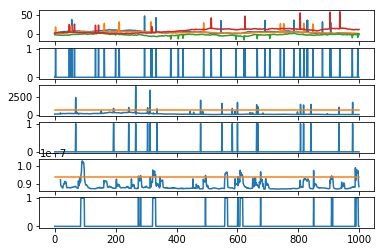

                    dataset      approach  accuracy  precision    recall  \
0  synthetic_data_generator  RecurrentEBM     0.942   0.000000  0.000000   
1  synthetic_data_generator        LSTMAD     0.908   0.035088  0.051282   

   F1-score  fpr  
0  0.000000  0.0  
1  0.041667  0.0  


TypeError: Expected sequence or array-like, got <class 'float'>

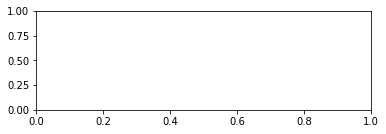

In [11]:
datasets = [synthetic_data_generator("extreme")]
detectors = [RecurrentEBM(num_epochs=15), LSTMAD()]
evaluator = Evaluator(datasets, detectors)
evaluator.evaluate()
df = evaluator.benchmarks()
print(df)
evaluator.plot_scores()

In [3]:
def main():
    data_generator = synthetic_data_generator()
    X_train, y_train, X_test, y_test = data_generator.generate_outliers("extreme")
    
    y_binary = [] # predicted binary labels of all models
    y_scores = [] # error measures of each prediction
    
    ReEBM = RecurrentEBM(num_epochs=15)
    ReEBM.fit(X_train, None)
    ReEBM_scores = ReEBM.predict(X_test)
    ReEBM_binary = binary_label(ReEBM_scores)
    y_binary.append(ReEBM_binary)
    plot_scores(X_test, y_test, ReEBM_scores, 100)
    
    dagmm = DAGMM()
    dagmm.fit(X_train.values, y_train)
    dagmm_binary, dagmm_scores, dagmm_threshold = dagmm.predict(X_test.values)
    y_binary.append(dagmm_binary)
    plot_scores(X_test, y_test, dagmm_scores, 1, dagmm_threshold)
    
    lstmad = LSTMAD()
    lstmad.fit(X_train.values, None)
    lstmad_scores = lstmad.predict(X_test.values)
    lstmad_binary = binary_label(lstmad_scores, 0)
    y_binary.append(lstmad_binary)
    plot_scores(X_test, y_test, lstmad_scores, 2, 0)
    
    working_models = ["Recurrent EBM", "DAGMM"]#, "LSTM-AD"]
    evaluate(y_test.values, y_binary, working_models)

if __name__ == '__main__':
    main()

AttributeError: 'synthetic_data_generator' object has no attribute 'generate_outliers'

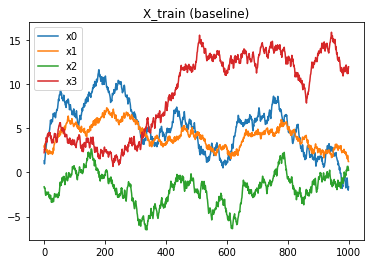

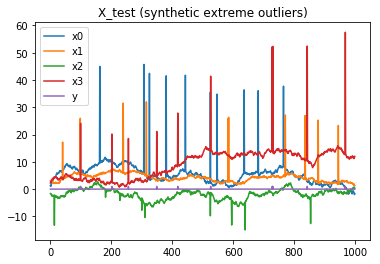

In [7]:
data_generator = synthetic_data_generator()
X_train, y_train, X_test, y_test = data_generator.generate_outliers("extreme")

In [15]:
import pickle

file = open("synth_test_240518", "wb")
pickle.dump((X_train, y_train, X_test, y_test), file)
file.close()

In [16]:
file = open("synth_test_240518", "rb")
(X_train, y_train, X_test, y_test) = pickle.load(file)
file.close()
print(X_train)

           x0        x1        x2         x3
0    1.330106  3.000000 -1.618891   2.244998
1    0.970960  2.790380 -1.795467   2.680267
2    1.291141  3.230361 -1.730158   2.530218
3    1.688795  3.030049 -1.902327   2.912778
4    2.117202  3.101420 -2.401386   3.129198
5    2.236750  2.531633 -2.587374   3.499921
6    2.694172  2.542660 -2.584866   3.482068
7    3.075173  2.368553 -2.213396   3.974022
8    3.388750  2.322347 -2.312049   3.697179
9    3.581006  2.601257 -2.461260   3.443867
10   3.773993  2.352826 -2.412291   3.870973
11   4.111683  2.458104 -2.431246   4.302865
12   4.228416  2.116392 -2.223833   4.032573
13   4.393512  2.245651 -2.477895   4.380917
14   4.351225  2.084498 -2.246012   4.485671
15   4.267110  2.093032 -2.645337   4.172977
16   4.398179  2.167899 -2.526294   4.222625
17   4.704278  2.518646 -2.865580   4.542885
18   4.882382  2.232061 -2.537322   4.415750
19   5.230420  2.428251 -2.979748   4.525996
20   5.490355  2.144746 -2.790999   4.294788
21   5.950